In [2]:
### Averaging epochs and export trial data

import glob
import os

import numpy as np

import mne

# Preallocate lists for collecting subject averages
list_base_a = []
list_base_b = []

In [4]:
%%capture
# Load all epochs for the baseline condition
path = './epochs/'  
for file in glob.glob(os.path.join(path, '*base-epo.fif')):
    
    # Load all epochs
    epochs = mne.read_epochs(file, preload=True)
    # Crop the data to have a shorter baseline
    epochs.crop(-0.25, epochs.tmax)
    
    # Perform a baseline correction (250 before stimulus onset till the onset)
    epochs.apply_baseline(baseline=(-0.25, 0))
    
    # Average the relevant conditions
    evoked_a = epochs['A'].average()
    evoked_b = epochs['B'].average()

    # Collect ERPs in a list for each condition
    list_base_a.append(evoked_a)
    list_base_b.append(evoked_b)

In [5]:
# Create grand averages and a difference wave
cueA_base = mne.grand_average(list_base_a)
cueB_base = mne.grand_average(list_base_b)

diff_base = mne.combine_evoked((cueA_base,cueB_base),[-1,1])

Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.


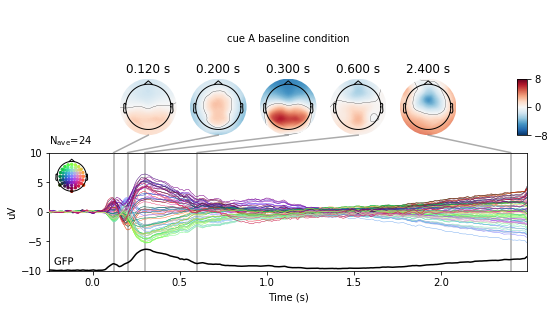

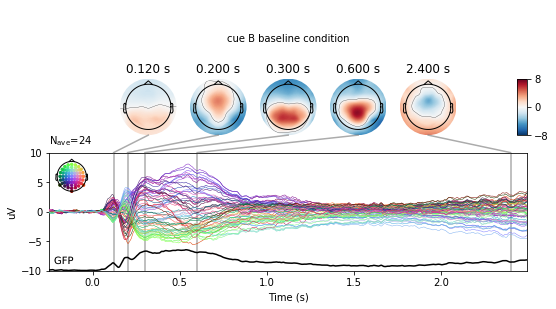

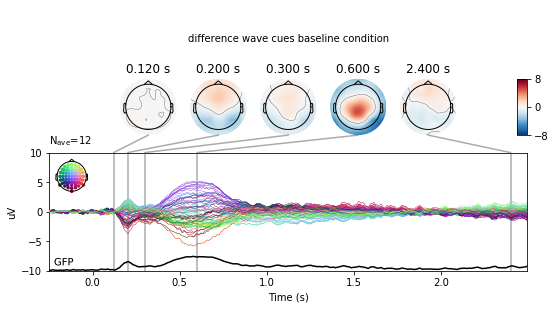

In [13]:
# Plot the results
ts_args = dict(gfp=True, zorder='std',
               ylim =dict(eeg=[-10,10]), unit=True)
topomap_args = dict(sensors=False, vmax=8, vmin=-8, average=0.025, contours=2)
times = [.12, .2, .3, .6, 2.4]

fig1 = cueA_base.plot_joint(times=times, ts_args=ts_args, 
                            topomap_args=topomap_args,
                            title='cue A baseline condition')

fig2 = cueB_base.plot_joint(times=times, ts_args=ts_args, 
                            topomap_args=topomap_args,
                            title='cue B baseline condition')

fig3 = diff_base.plot_joint(times=times, ts_args=ts_args, 
                            topomap_args=topomap_args,
                            title='difference wave cues baseline condition')

In [ ]:
# Save all figures
fig1.savefig('./plots/a_base.pdf', bbox_inches='tight')
fig2.savefig('./plots/b_base.pdf', bbox_inches='tight')
fig3.savefig('./plots/diff_cues_base.pdf', bbox_inches='tight')

In [ ]:
# Export the data
# The following export loop can be performed analogously for
# baseline and the dual regulation condition as well as the
# different cue- and probe-locked epochs

# Set up subject list accounting for groups
ppm_indices = '101','104','107','108','114','120','121','122','123','124','126'
ppp_indices = '102','103','106','112','113','115','116','117','118','119','125', '201', '202'

# Write the index labels for the data frames
index = ['epoch', 'time']

In [ ]:
%%capture
data_path = './epochs'
for file in glob.glob(os.path.join(data_path, '*base-epo.fif')):
    
    filepath, filename = os.path.split(file)
    filename, ext = os.path.splitext(filename)

    current_epochs = mne.read_epochs(file)
    current_epochs.apply_baseline(baseline=(-0.25,0))
    
    # Crop the data according to the required time windows
    # for the P3 and the sustained positivity respectively
    sp = current_epochs['A'].copy().crop(tmin=0.5, tmax=0.65)
    p3 = current_epochs['A'].copy().crop(tmin=0.35, tmax=0.5)
    
    # Create the amplitude data frames
    sp = sp.to_data_frame(picks=[30], index=index)
    p3 = p3.to_data_frame(picks=[30], index=index)
    
    # Average over sample points contained in the time windows
    sp = sp.mean(level='epoch')
    p3 = p3.mean(level='epoch')
    
    # Enter the corresponding block to each line
    # and append it as an additional column to the data frame
    block = [2]*int(np.floor(sp.size/2))
    block = [2]*int(np.floor(sp.size/2)) + [3]*(sp.size-len(block))
    block = pd.DataFrame(block)
    
    # Analogous to the block column, add the group for
    # each subject
    if any(x in (filename[:-8]) for x in ppm_indices):
        group = pd.DataFrame([0]*len(block))
    elif any(x in (filename[:-8]) for x in ppp_indices):
        group = pd.DataFrame([1]*len(block))
    
    # Note the condition (baseline vs dual regulation)
    # and the subject number
    condition = pd.DataFrame([0]*len(block))
    subject = pd.DataFrame([filename[:-8]]*len(block))
    
    # Concatenate all data frames
    p3 = pd.concat([subject,p3,block,group,condition], axis=1)
    sp = pd.concat([subject,sp,block,group,condition], axis=1)

    # Add the subject to the data frame containing all subjects
    if file == './epochs/101_reg-epo.fif':
        df_base_p3_epochs = p3.round(3)
        df_base_sp_epochs = sp.round(3)
    else:
        p3 = p3.round(3)
        df_base_p3_epochs = pd.concat([df_base_p3_epochs,p3],axis=0)
        sp = sp.round(3)
        df_base_sp_epochs = pd.concat([df_base_sp_epochs,sp],axis=0)

In [ ]:
# Save the finished data frames to csv files
df_base_p3_epochs.to_csv('./epochs_csv/baseline_a_p3_epochs.csv')
df_base_sp_epochs.to_csv('./epochs_csv/baseline_a_sp_epochs.csv')